## Notebook Purpose
This notebook is used to plot bin-wise Lagrangian SMB profile with respect to debris thickness and elevation (Supplementary Figure 6).

#### Last updated: May, 2023

## TODO:
- Update imports when new library has been built up with all updates
-Generalise path to data products during revisions, after the data distribution plan is finalized


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'


In [3]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from velocity_proc import glac_dyn, constants, velocity_filter,velocity_timeseries
import warnings
warnings.filterwarnings('ignore')

/swbuild/sbhusha1/miniconda3/envs/bhushanGDAL3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%matplotlib inline


## Test with Khumbu Glacier

In [5]:
%cd /nobackup/sbhusha1/chapter2/

/nobackupp11/sbhusha1/chapter2


In [6]:
lirung_df = pd.read_csv('lirung/202320218/lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')

lirung_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')

In [7]:
lirung_df.keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm', 'z_area', 'z_bin_centers'],
      dtype='object')

In [8]:
def boxplot_stats_aggregator(df):
    debris_boxes_list_nowhisker = []    
    for idx,rows in df.iterrows():

        debris_box_temp = {
                'label':rows['z_bin_centers'],
                'positions':rows['z_bin_centers'],
                'whislo':rows['q1_deb_thick'],
                'q1':rows['q1_deb_thick'],
                'med':rows['med_deb_thick'],
                'q3':rows['q3_deb_thick'],
                'whishi':rows['q3_deb_thick'],
                'fliers':[]
            }
        debris_boxes_list_nowhisker.append(debris_box_temp)
    return debris_boxes_list_nowhisker

In [9]:
debris_box_plot = boxplot_stats_aggregator(lirung_df)

In [10]:
lirung_df.keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm', 'z_area', 'z_bin_centers'],
      dtype='object')

In [11]:
(lirung_df['area_total']*lirung_df['med_total_dhdt']).sum()/(lirung_df['area_total'].sum())

-1.811922967532345

In [12]:
melt_df = lirung_df

In [13]:
def plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim,xlim):
    f,ax = plt.subplots(3,1,sharex=True,figsize=(5,5),gridspec_kw={"height_ratios":[2.5,1.5,1]})
    area_wt_mb = (melt_df['area_total']*melt_df['med_total_dhdt']).sum()/(melt_df['area_total'].sum())
    mb_text = f"{np.round(area_wt_mb,2)} m/yr"
    t = ax[0].text(0.70,0.85,mb_text,
    color='red', fontsize=12,transform=ax[0].transAxes)
    #ax2=ax[0].twinx()
    #ax2.bar(melt_df.z_bin_centers,melt_df.area_total,color='brown',width=100)
    ax[0].plot(melt_df.z_bin_centers,melt_df.med_total_dhdt,color='red')
    ax[0].fill_between(melt_df.z_bin_centers,melt_df.med_total_dhdt-melt_df.nmad_total_dhdt,
                    melt_df.med_total_dhdt+melt_df.nmad_total_dhdt,color='red',alpha=0.5)
    ax[0].set_title(title)
    #ax.set_xlabel('Elevation (m)')

    ax[0].set_ylabel(r'$\frac{\dot{{b}_{s}}}{\rho}\;(m/yr)$ ')
    ax[0].set_ylim(ylim)
    ax[0].axhline(0,linestyle='--',c='k')

    c = 'brown'
    debris_box_p = ax[1].bxp(debris_box_plot,showfliers=False,positions=melt_df.z_bin_centers.values,widths=50,
                            patch_artist=True)
    plt.setp(debris_box_p['boxes'], color='k')
    plt.setp(debris_box_p['medians'], color='k')
    plt.setp(debris_box_p["boxes"], facecolor=c)
    #for idx in range(len(debris_box_p['boxes'])):
     #   boxes.set(facecolor='gray')
    ax[1].set_ylim(0,3)
    ax[1].set_xticks(np.arange(xlim[0],xlim[1],400))
    
    ax[1].set_xticklabels(np.arange(xlim[0],xlim[1],400))
    #ax[1].set_yscale('log')
    ax[1].set_ylabel(r'$Deb.\:thick.\:(m)$ ')

    ax[2].bar(melt_df.z_bin_centers,melt_df.area_total,width=50,color='gray',edgecolor='black')
    ax[2].set_ylabel(r'$Area\:(km^2)$ ')
    ax[2].set_xlabel(r'$Elevation\:(m)$ ')
    ax[2].set_xlim(xlim)
    ax[2].set_ylim(0,2)
    t = ax[0].text(0.020,0.92,'(i)',
    color='black', fontsize=10,transform=ax[0].transAxes)
    #t.set_bbox(dict(facecolor='gray', alpha=1, edgecolor='gray'))
    t = ax[1].text(0.020,0.86,'(ii)',
    color='black', fontsize=10,transform=ax[1].transAxes)
    #t.set_bbox(dict(facecolor='gray', alpha=1, edgecolor='gray'))
    t = ax[2].text(0.020,0.82,'(iii)',
    color='black', fontsize=10,transform=ax[2].transAxes)
    #t.set_bbox(dict(facecolor='gray', alpha=1, edgecolor='gray'))
    plt.tight_layout()
    return f,ax

In [14]:
melt_df

,med_bg_dhdt,nmad_bg_dhdt,q1_bg_dhdt,q3_bg_dhdt,area_bg,med_hotspot_dhdt,nmad_hotspot_dhdt,q1_hotspot_dhdt,q3_hotspot_dhdt,area_hotspot,...,med_deb_thick,nmad_deb_thick,q1_deb_thick,q3_deb_thick,med_vm,nmad_vm,q1_vm,q3_vm,z_area,z_bin_centers
0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,...,0.55,0.00,0.545655,0.552802,0.11,0.04,0.067622,0.133615,0.001212,3925.0
1,-0.24,0.19,-0.384313,-0.128174,0.165204,-3.62,0.86,-4.435288,-3.167065,0.000740,...,0.48,0.16,0.364308,0.584876,0.33,0.07,0.285846,0.389451,0.213532,3975.0
2,-1.06,0.56,-1.620192,-0.749121,0.050140,-6.78,4.39,-11.056680,-4.203600,0.018872,...,0.48,0.14,0.314378,0.555559,1.05,0.30,0.749713,1.215393,0.120992,4025.0
3,-0.73,0.45,-1.054050,-0.447351,0.131276,-3.79,1.14,-5.231359,-3.176817,0.002808,...,0.41,0.18,0.292905,0.530126,1.16,0.16,1.038118,1.259918,0.169044,4075.0
4,-0.55,0.35,-0.817556,-0.333615,0.138736,-3.37,0.13,-3.428578,-3.292036,0.000024,...,0.48,0.09,0.396847,0.534027,1.39,0.68,0.997817,2.150293,0.182848,4125.0
5,-0.86,0.50,-1.175910,-0.493719,0.144160,-4.77,2.08,-6.867153,-3.547835,0.001852,...,0.51,0.05,0.467710,0.540997,1.78,1.34,0.976051,2.805764,0.211164,4175.0
6,-2.02,1.73,-3.722078,-0.978439,0.298968,-3.72,1.50,-6.203577,-3.045307,0.019800,...,0.34,0.06,0.301634,0.381142,2.75,0.71,2.155325,3.176775,0.398356,4225.0
7,-4.60,3.36,-6.713135,-2.143151,0.218852,-6.83,1.38,-7.798949,-6.018771,0.000856,...,0.22,0.04,0.181031,0.234199,3.10,1.55,2.194561,4.325291,0.330036,4275.0
8,-3.87,1.68,-4.920011,-2.586046,0.035868,-2.92,0.92,-4.715168,-2.564774,0.000276,...,0.16,0.04,0.120215,0.180636,1.37,1.00,0.847945,2.811527,0.104936,4325.0
9,0.86,0.94,0.125476,1.426208,0.005700,-4.71,2.79,-8.805803,-3.457288,0.000188,...,0.16,0.01,0.128062,0.165048,0.81,0.20,0.554546,0.847019,0.022192,4375.0


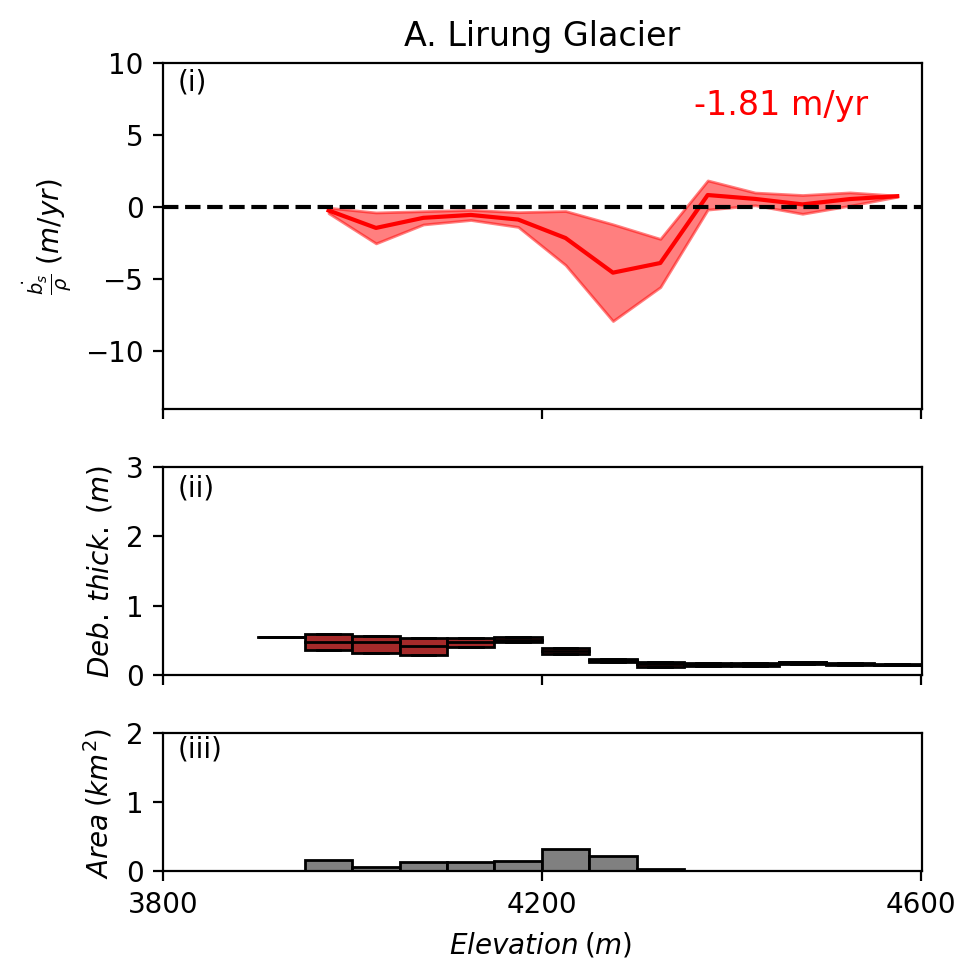

In [15]:
melt_df = pd.read_csv('lirung/202320218/lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'A. 20161106 to 20171222'
title = 'A. Lirung Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(3800,4601))
f.savefig('figures/lirung_profile.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
#plot_glacier_meltcurve(melt_df,debris_box_plot,'Lirung Glacier 2016-11-06 to 2017-12-22',ylim=(-14,10),xlim=(3900,4600))

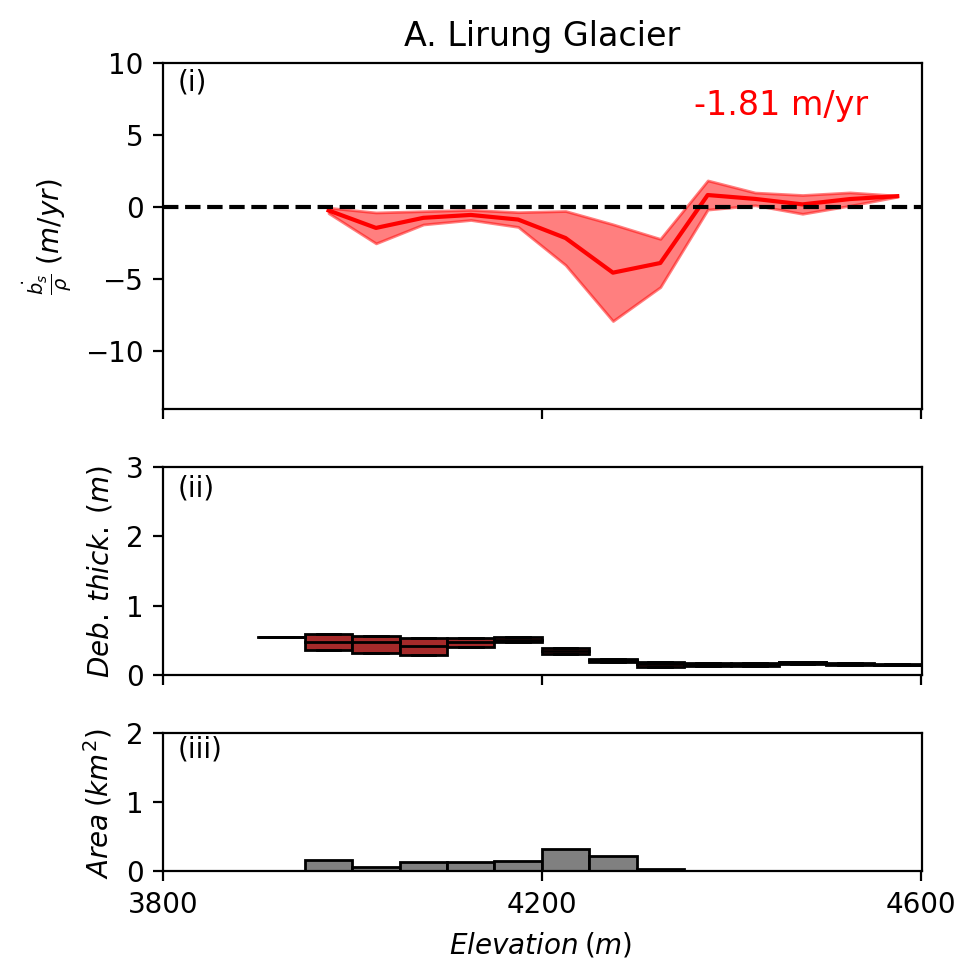

In [16]:
melt_df = pd.read_csv('lirung/202320218/lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'A. 20161106 to 20171222'
title = 'A. Lirung Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(3800,4601))
f.savefig('figures/lirung_profile_log_scale.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
#plot_glacier_meltcurve(melt_df,debris_box_plot,'Lirung Glacier 2016-11-06 to 2017-12-22',ylim=(-14,10),xlim=(3900,4600))

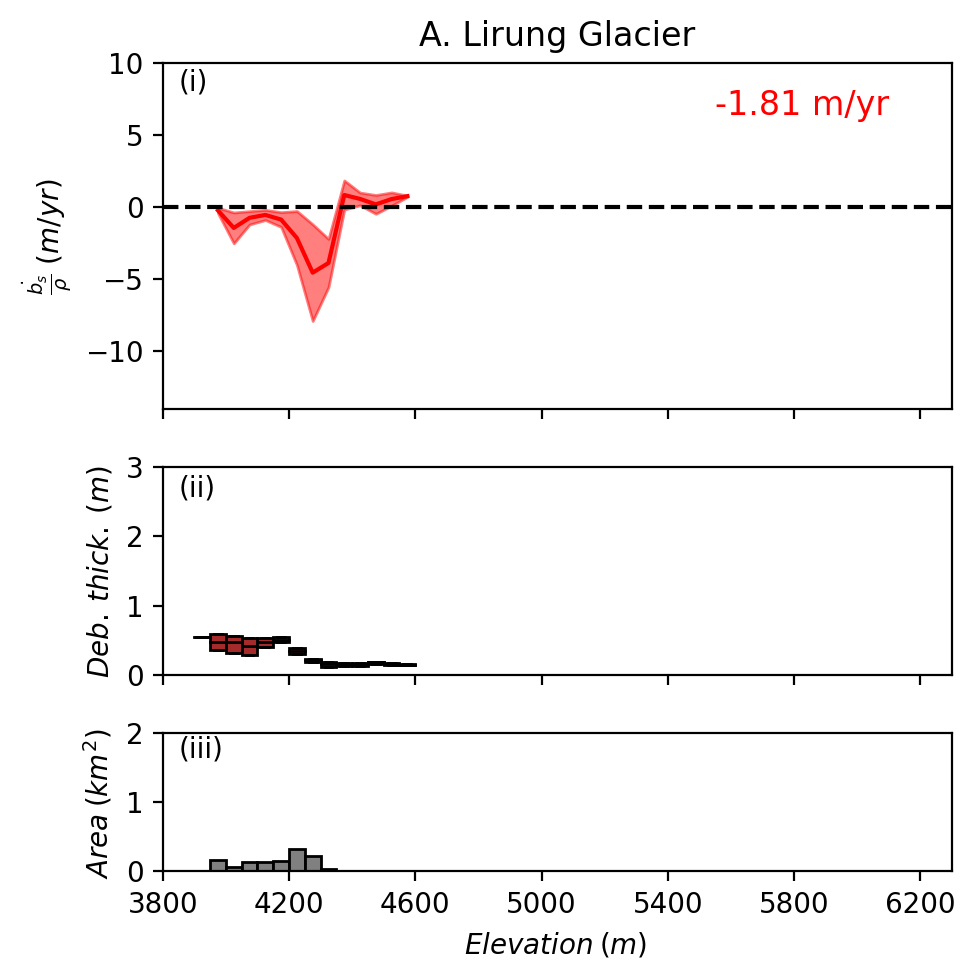

In [18]:
melt_df = pd.read_csv('lirung/202320218/lirung_farinotti_2016-11-06_to_2017-12-22_lag_smb_products/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'A. 20161106 to 20171222'
title = 'A. Lirung Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(3800,6300))
f.savefig('figures/lirung_profile_log_scale_common.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Langtang Glacier

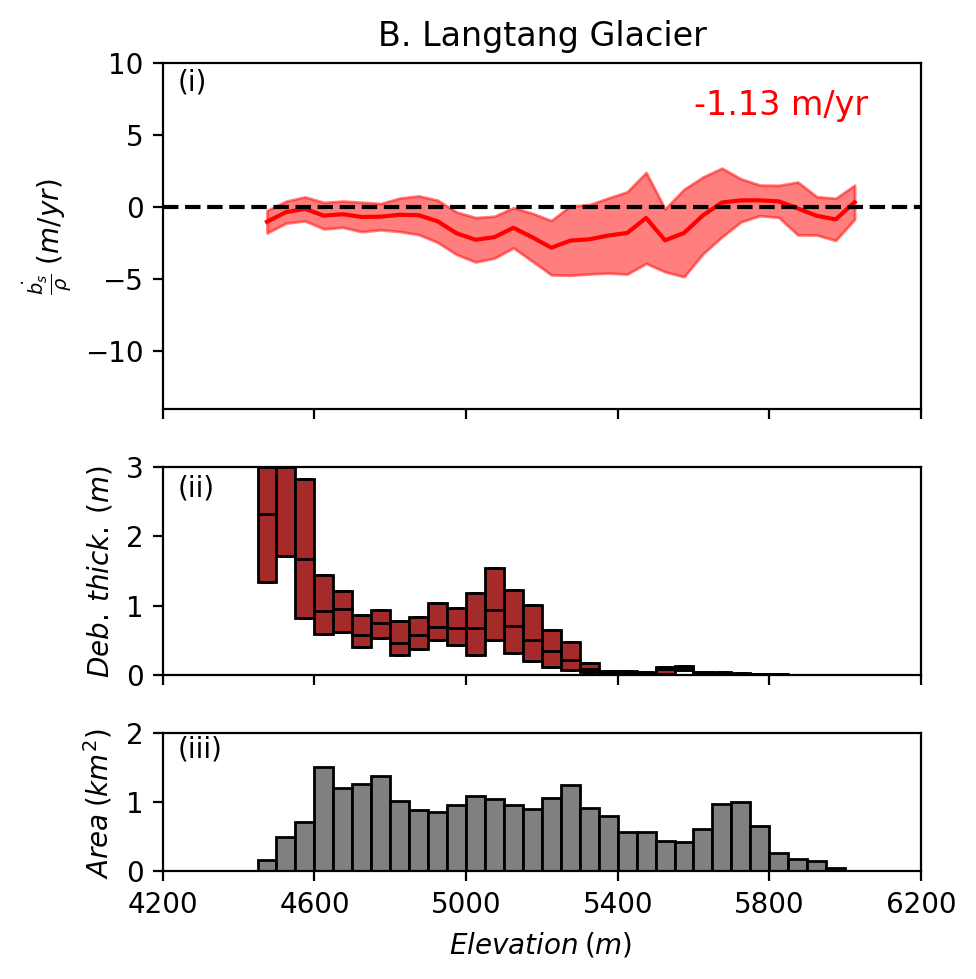

In [19]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/langtang/dem_dir/aligned_dems/hillshades/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_f*melt*.csv'))[0])
melt_df = pd.read_csv('langtang/20230223/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Langtang Glacier 2015-02-22 to 2016-01-07'
title = 'B. Langtang Glacier'
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=)
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4200,6201))
f.savefig('figures/langtang_profile.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

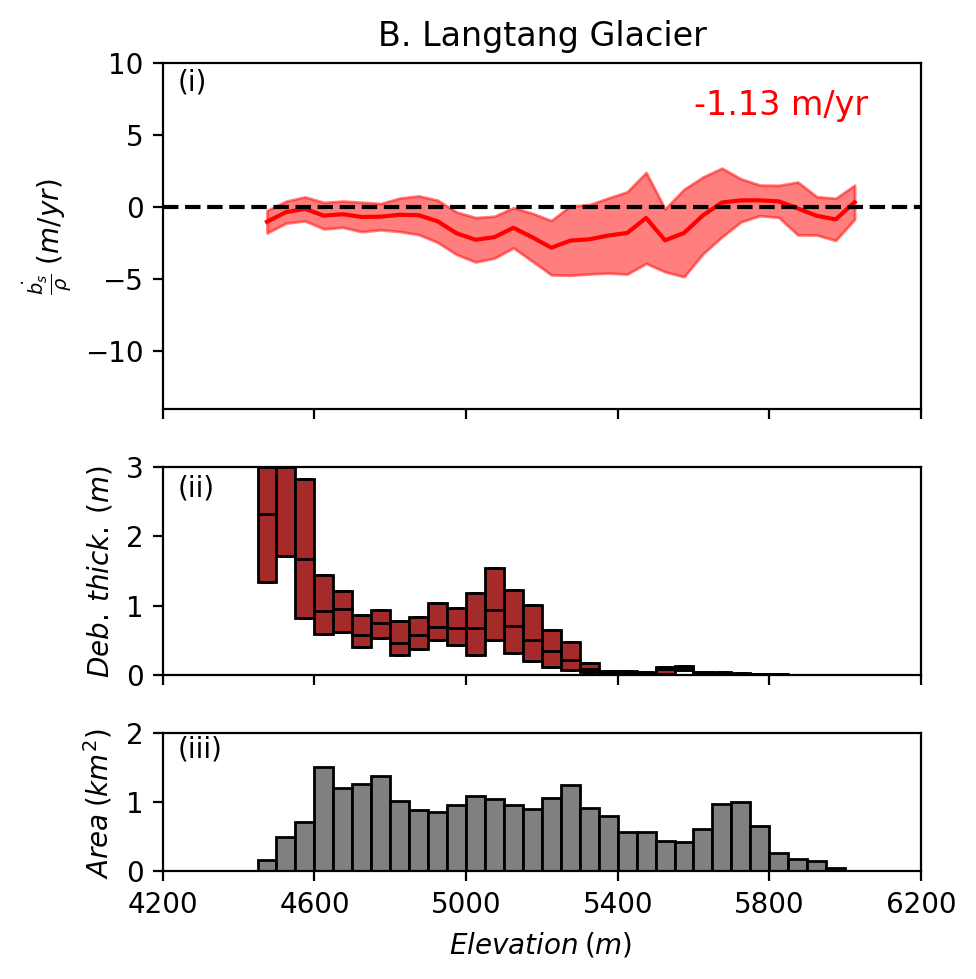

In [20]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/langtang/dem_dir/aligned_dems/hillshades/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_f*melt*.csv'))[0])
melt_df = pd.read_csv('langtang/20230223/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Langtang Glacier 2015-02-22 to 2016-01-07'
title = 'B. Langtang Glacier'
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=)
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4200,6201))
f.savefig('figures/langtang_profile_log_scale.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

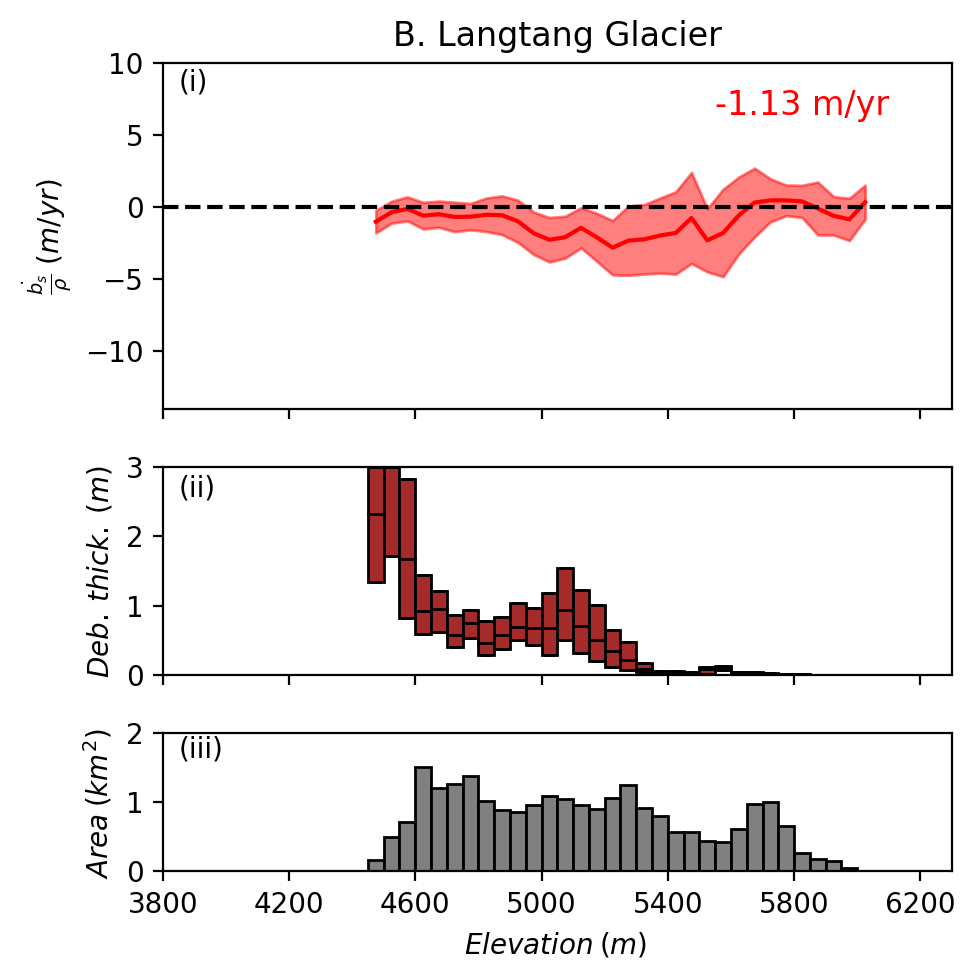

In [21]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/langtang/dem_dir/aligned_dems/hillshades/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_f*melt*.csv'))[0])
melt_df = pd.read_csv('langtang/20230223/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Langtang Glacier 2015-02-22 to 2016-01-07'
title = 'B. Langtang Glacier'
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=)
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(3800,6300))
f.savefig('figures/langtang_profile_log_scale_common.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Ngozumpa

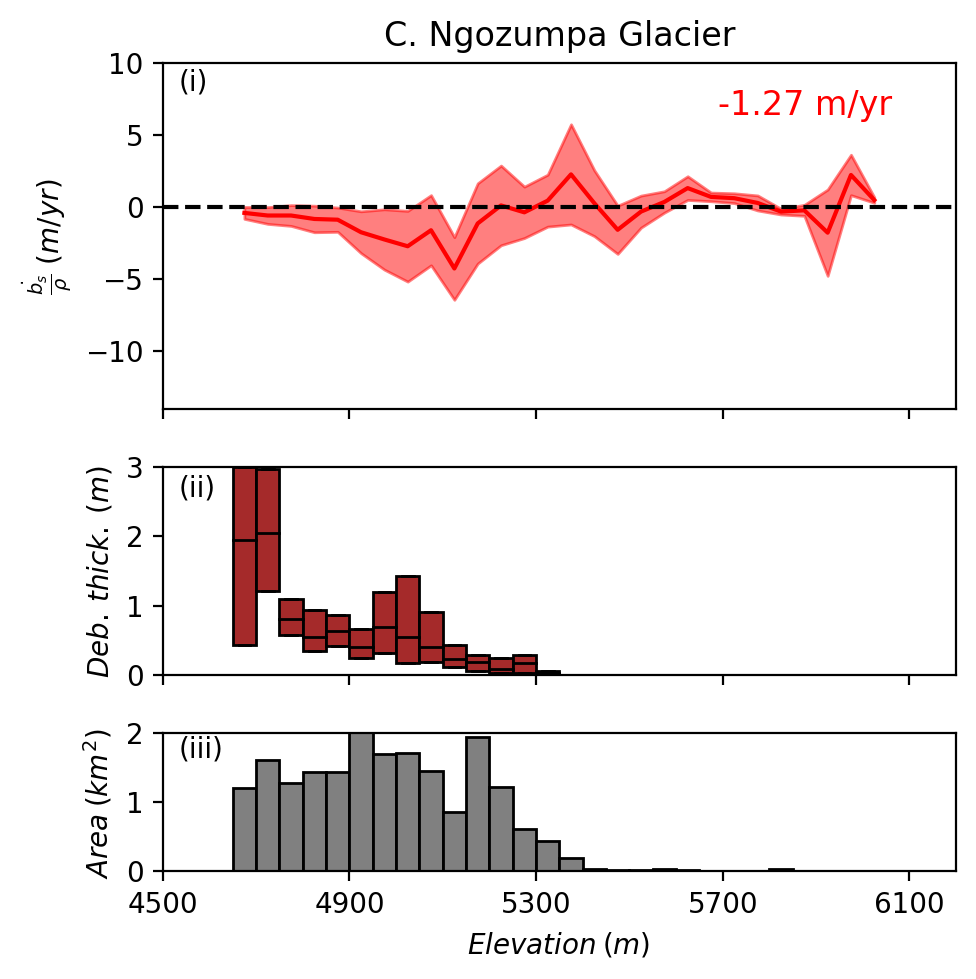

In [22]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('ngozumpa/20230217/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'
title = 'C. Ngozumpa Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4500,6201))
f.savefig('figures/ngozumpa_profile.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


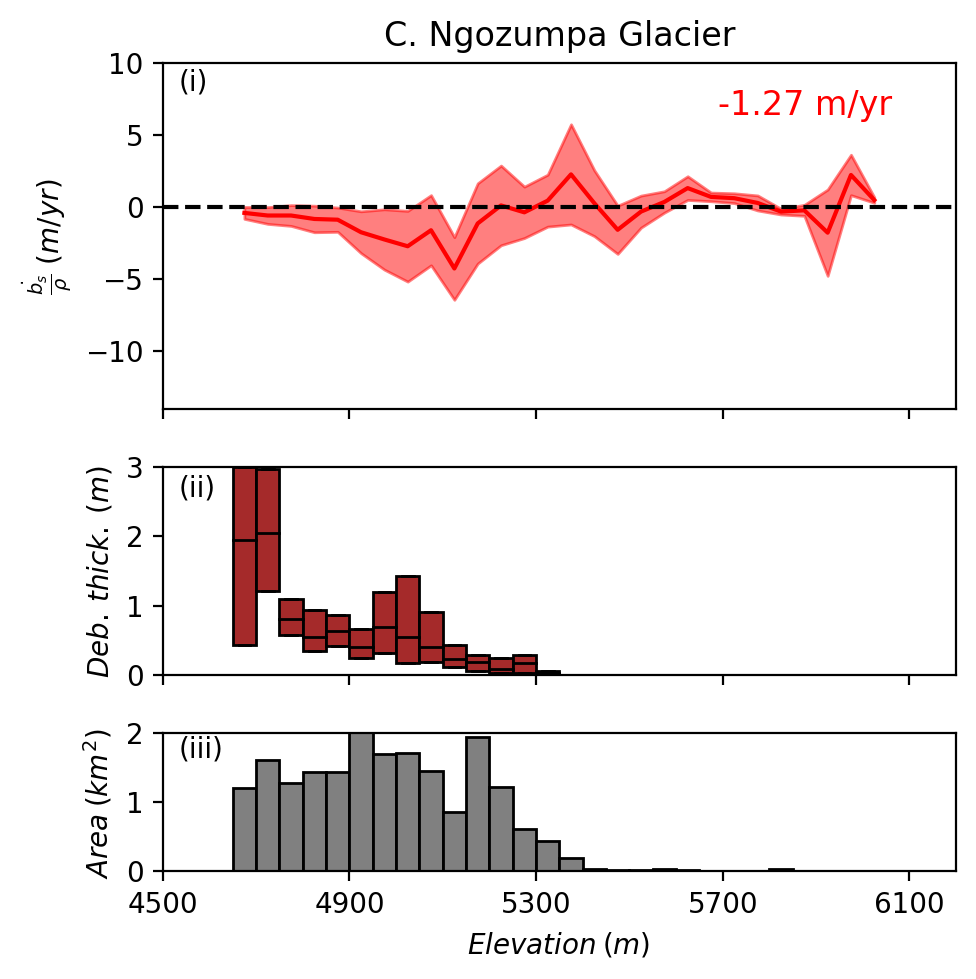

In [23]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('ngozumpa/20230217/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'
title = 'C. Ngozumpa Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4500,6201))
f.savefig('figures/ngozumpa_profile_log_scale.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


## Black Changri Nup

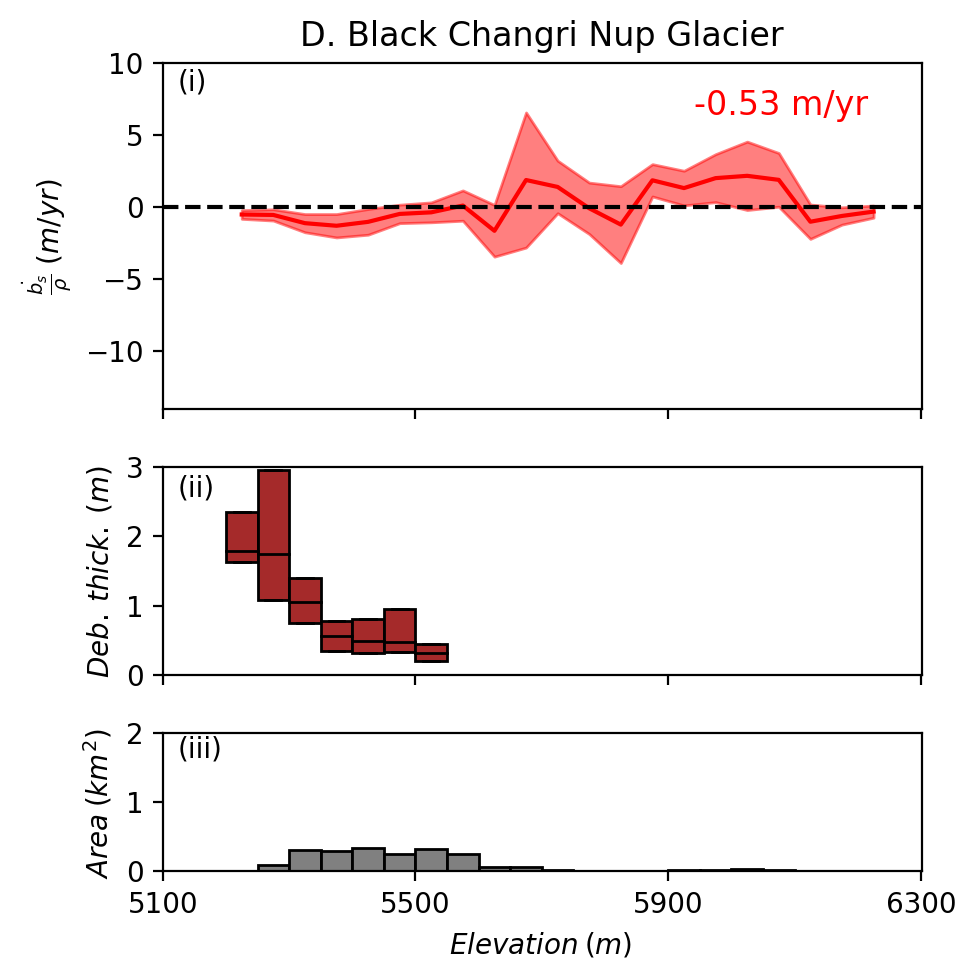

In [24]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
melt_df = pd.read_csv('changrinup/20230217/black_changri_nup_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#,ylim=(-14,10),xlim=)
old_title = 'Black Changri Nup Glacier 2015-11-02 to 2016-10-25'
title = 'D. Black Changri Nup Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(5100,6301))
f.savefig('figures/black_changrinup_profile.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


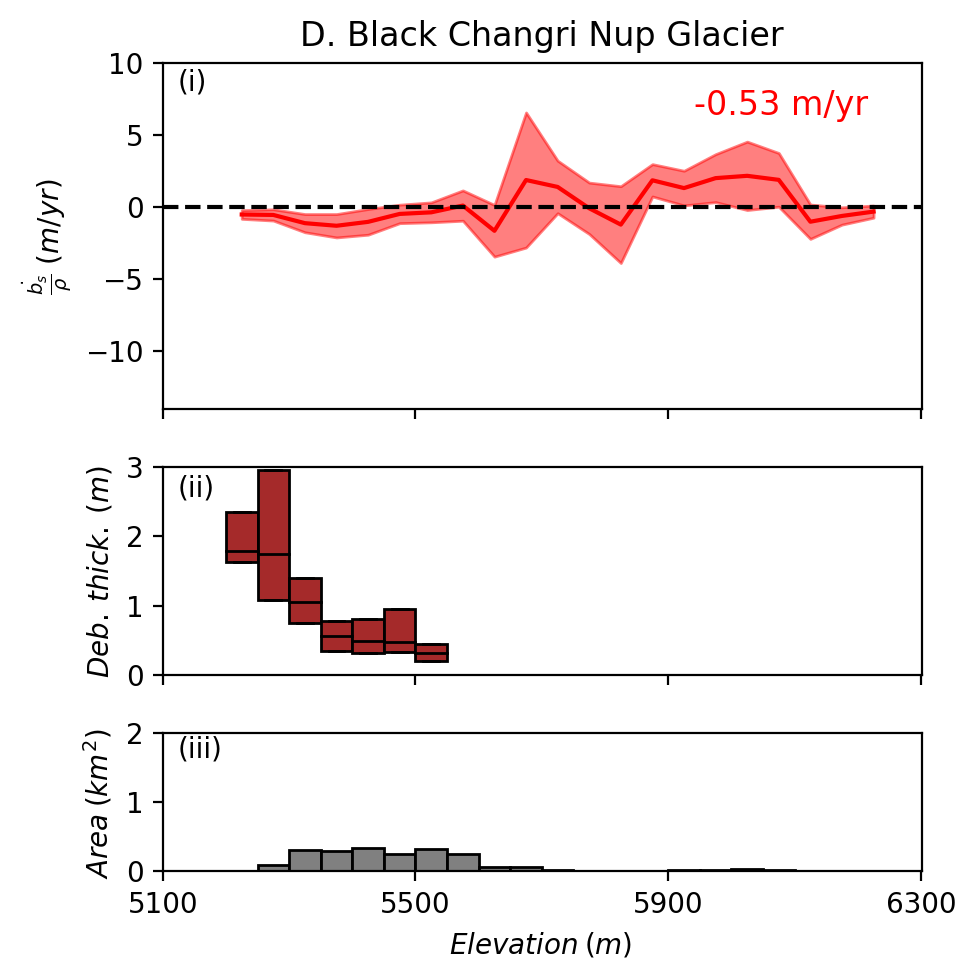

In [25]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
melt_df = pd.read_csv('changrinup/20230217/black_changri_nup_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#,ylim=(-14,10),xlim=)
old_title = 'Black Changri Nup Glacier 2015-11-02 to 2016-10-25'
title = 'D. Black Changri Nup Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(5100,6301))
f.savefig('figures/black_changrinup_profile_log_scale.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


## Khumbu Glacier

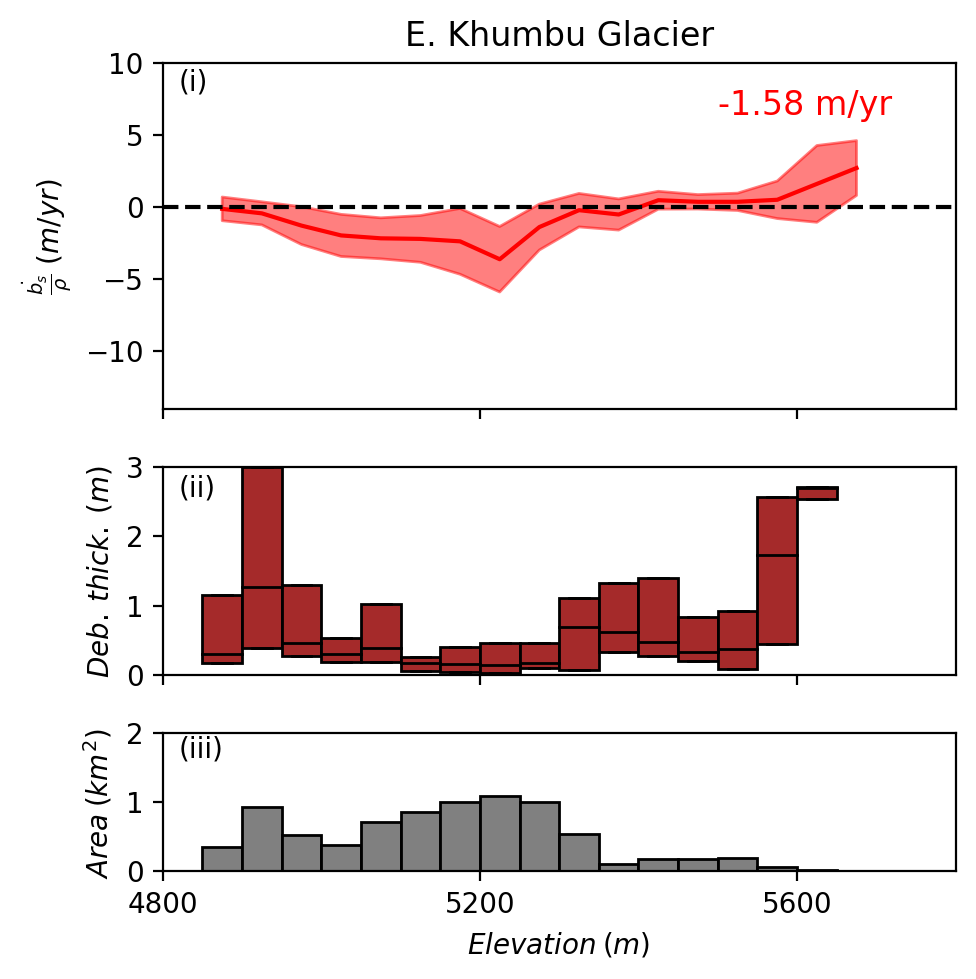

In [26]:
melt_df = pd.read_csv('changrinup/20230217/khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=(4800,5801))
old_title = 'Khumbu Glacier 2015-11-02 to 2016-10-25'
title = 'E. Khumbu Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4800,5801))
f.savefig('figures/khumbu_profile.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

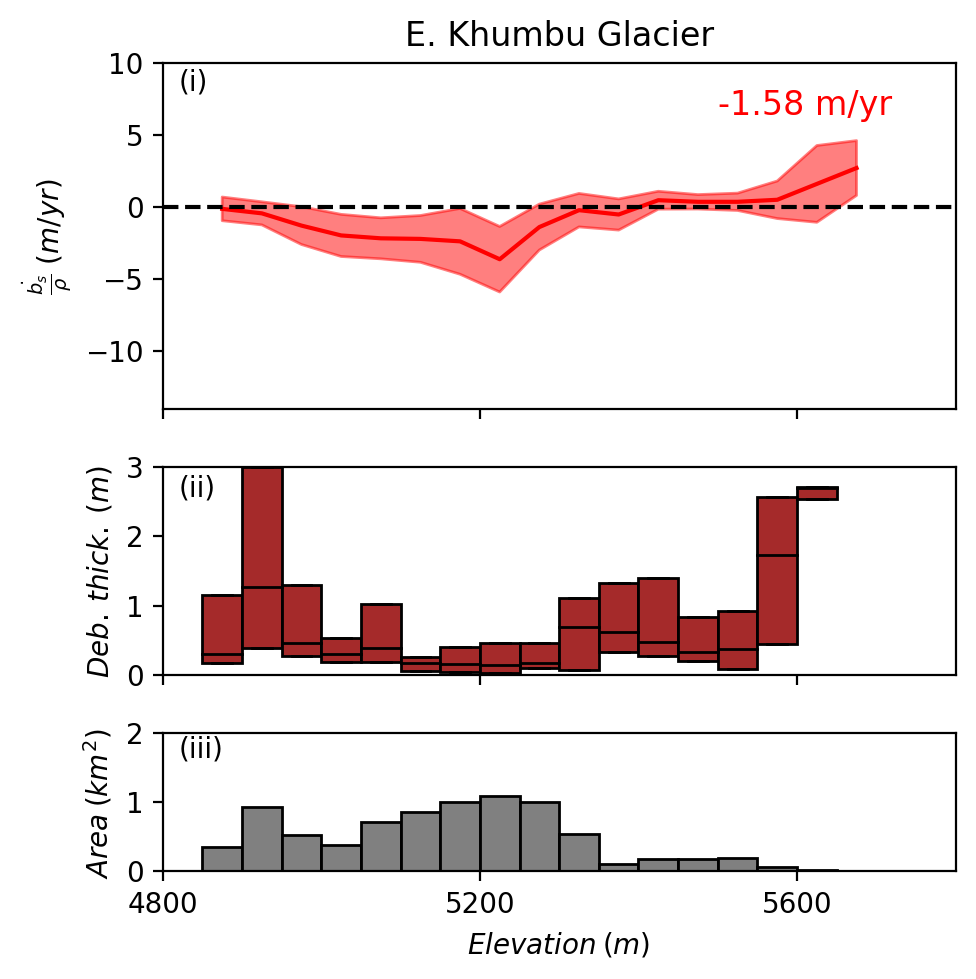

In [27]:
melt_df = pd.read_csv('changrinup/20230217/khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=(4800,5801))
old_title = 'Khumbu Glacier 2015-11-02 to 2016-10-25'
title = 'E. Khumbu Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4800,5801))
f.savefig('figures/khumbu_profile_log_scale.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Imja Glacier

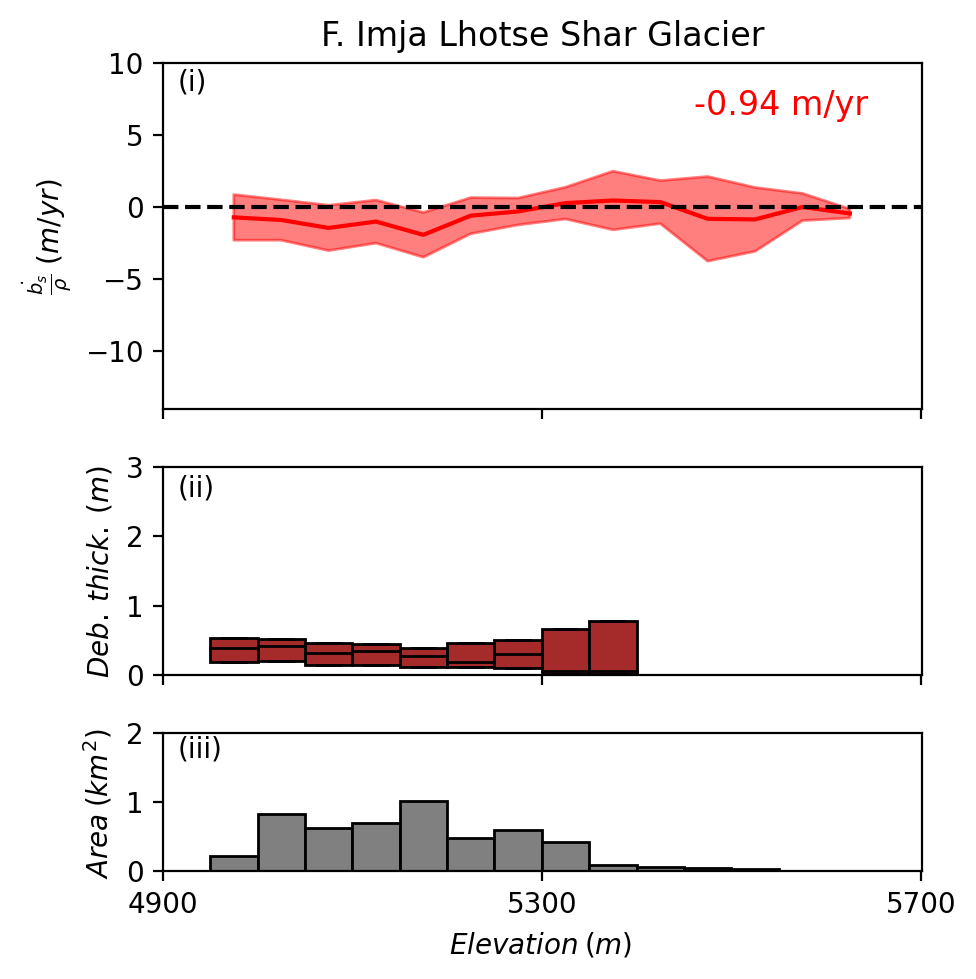

In [28]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/imja/dem_dir/aligned_dems/hstest/quick_test/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/*melt*.csv'))[0])
melt_df = pd.read_csv('imja/20230223/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Imja Lhotse Shar Glacier 2015-10-02 to 2016-10-29'
title = 'F. Imja Lhotse Shar Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4900,5701))
f.savefig('figures/imja_profile.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

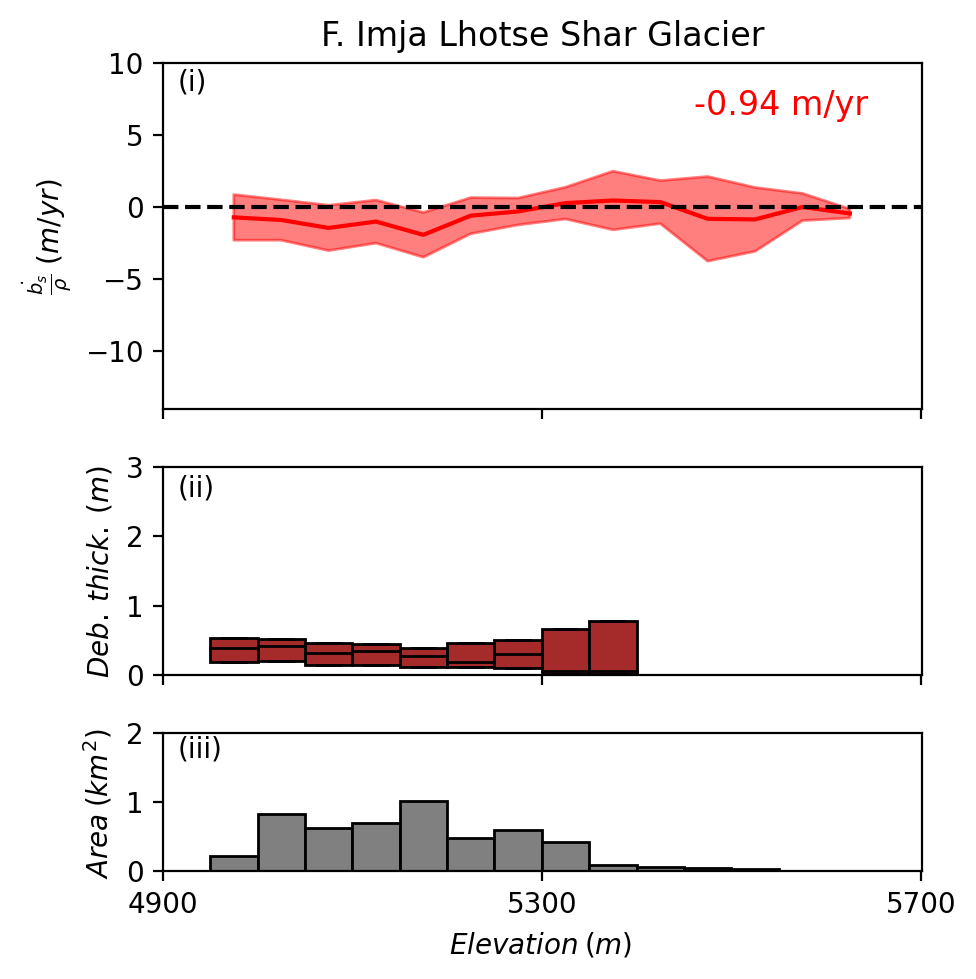

In [29]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/imja/dem_dir/aligned_dems/hstest/quick_test/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/*melt*.csv'))[0])
melt_df = pd.read_csv('imja/20230223/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Imja Lhotse Shar Glacier 2015-10-02 to 2016-10-29'
title = 'F. Imja Lhotse Shar Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4900,5701))
f.savefig('figures/imja_profile_log_scale.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Ngozumpa Glacier

In [30]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('ngozumpa/20230217/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)

(<Figure size 500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'}, ylabel='$\\frac{\\dot{{b}_{s}}}{\\rho}\\;(m/yr)$ '>,
        <Axes: ylabel='$Deb.\\:thick.\\:(m)$ '>,
        <Axes: xlabel='$Elevation\\:(m)$ ', ylabel='$Area\\:(km^2)$ '>],
       dtype=object))

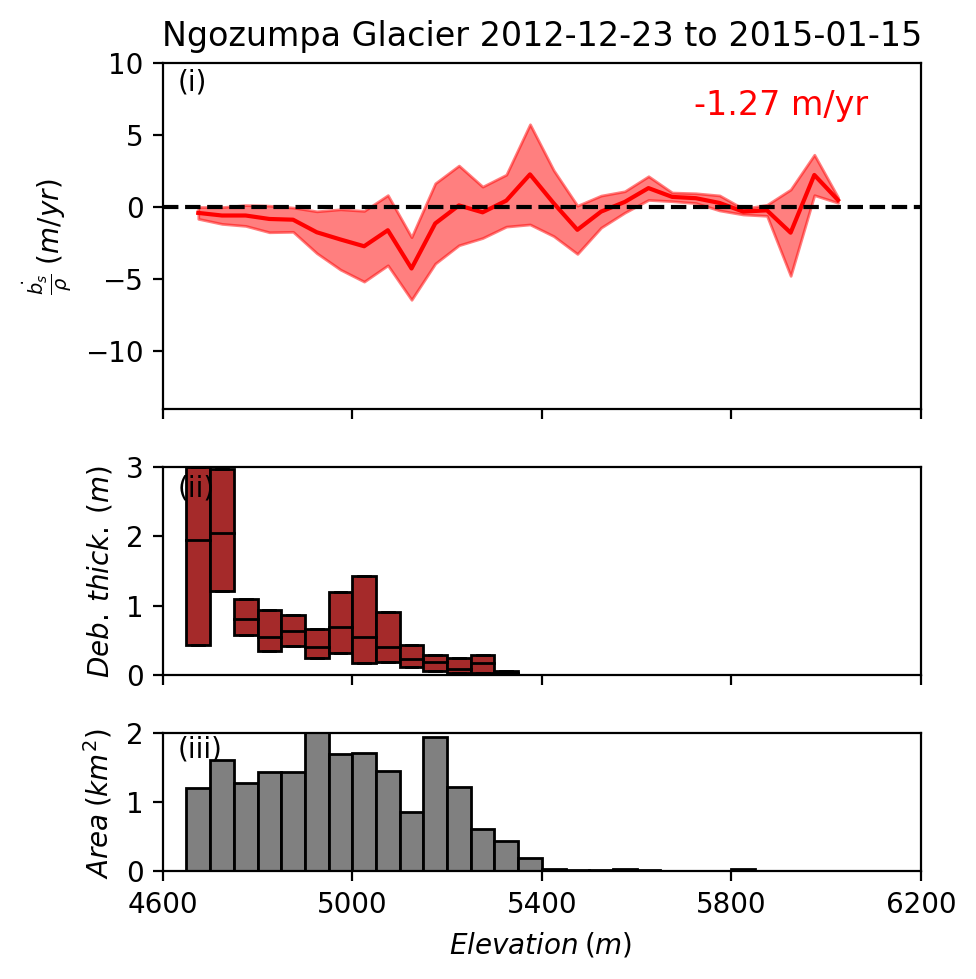

In [31]:
plot_glacier_meltcurve(melt_df,debris_box_plot,'Ngozumpa Glacier 2012-12-23 to 2015-01-15',ylim=(-14,10),xlim=(4600,6201))

## Black Changri Nup

In [34]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
melt_df = pd.read_csv('changrinup/20230217/black_changri_nup_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)

In [35]:
melt_df.head(5)

,med_bg_dhdt,nmad_bg_dhdt,q1_bg_dhdt,q3_bg_dhdt,area_bg,med_hotspot_dhdt,nmad_hotspot_dhdt,q1_hotspot_dhdt,q3_hotspot_dhdt,area_hotspot,...,med_deb_thick,nmad_deb_thick,q1_deb_thick,q3_deb_thick,med_vm,nmad_vm,q1_vm,q3_vm,z_area,z_bin_centers
0,-0.53,0.28,-0.705584,-0.313020,0.002040,NaN,NaN,NaN,NaN,0.000000,...,1.79,0.31,1.630725,2.356958,0.62,0.02,0.599608,0.635177,0.007408,5225.0
1,-0.54,0.38,-0.865623,-0.319702,0.087276,-3.88,1.24,-4.822039,-3.184001,0.001712,...,1.74,1.27,1.086174,2.959759,0.63,0.08,0.565513,0.678333,0.110312,5275.0
2,-1.07,0.58,-1.438057,-0.662104,0.281284,-4.32,1.53,-5.914143,-3.492979,0.020476,...,1.05,0.48,0.746854,1.398071,0.91,0.40,0.694009,1.288577,0.343896,5325.0
3,-1.21,0.71,-1.678353,-0.719654,0.269440,-4.19,1.47,-5.738635,-3.372207,0.028480,...,0.56,0.31,0.350662,0.771357,2.89,1.78,1.246755,3.686011,0.309472,5375.0
4,-0.93,0.81,-1.538794,-0.443965,0.302756,-3.70,0.83,-4.506242,-3.260263,0.013464,...,0.49,0.30,0.318442,0.802667,4.92,2.49,2.834610,6.328447,0.356512,5425.0


(<Figure size 500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Black Changri Nup Glacier 2015-11-02 to 2016-10-25'}, ylabel='$\\frac{\\dot{{b}_{s}}}{\\rho}\\;(m/yr)$ '>,
        <Axes: ylabel='$Deb.\\:thick.\\:(m)$ '>,
        <Axes: xlabel='$Elevation\\:(m)$ ', ylabel='$Area\\:(km^2)$ '>],
       dtype=object))

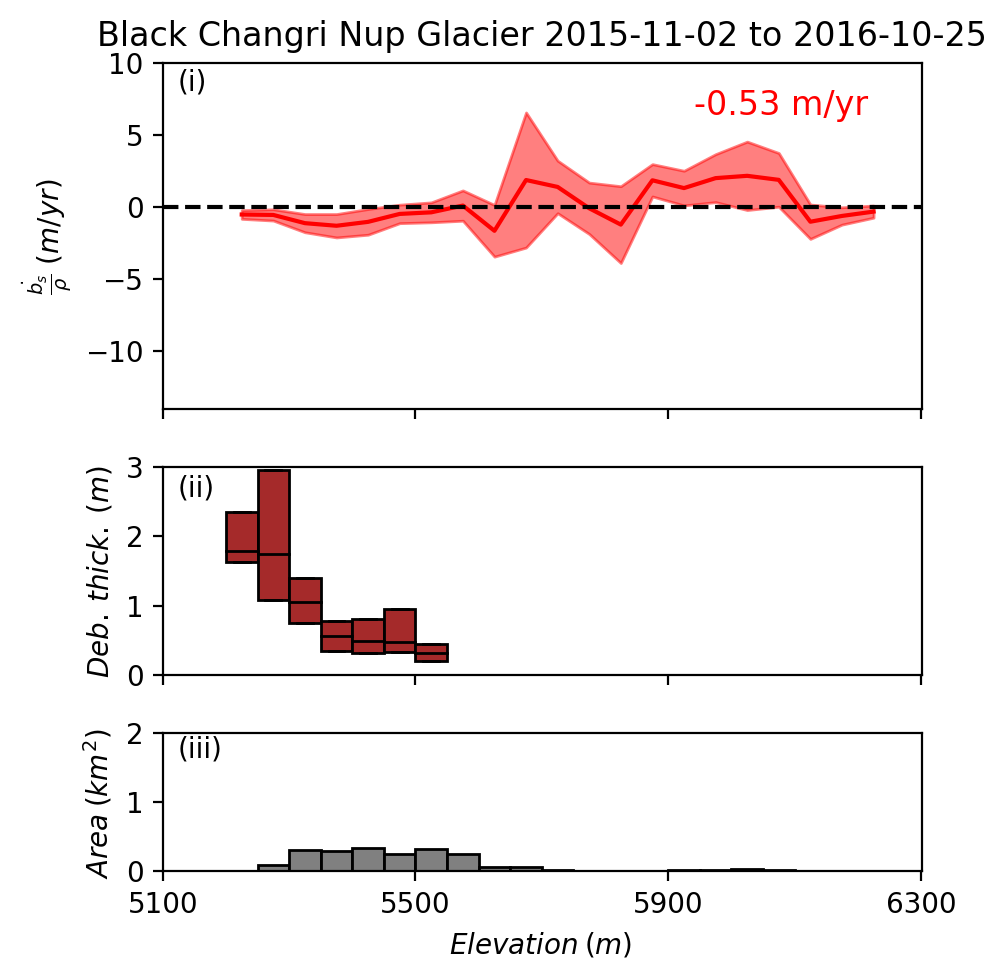

In [36]:
plot_glacier_meltcurve(melt_df,debris_box_plot,'Black Changri Nup Glacier 2015-11-02 to 2016-10-25',ylim=(-14,10),xlim=(5100,6301))